<a href="https://colab.research.google.com/github/Elma-dev/build_gpt_from_scratch/blob/main/build_llm_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [3]:
# q: quit mode
! pip install tiktoken -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00


# Import

In [4]:
# import pytorch module
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset,DataLoader

In [5]:
# import tiktoken
import tiktoken

# Code

In [6]:
# Build data reader
def data_reader(file_path:str):
  with open(file_path, 'r', encoding='utf-8') as f:
    data = f.read()
  return data

In [7]:
# create a data set creator
class DatasetV1(Dataset):
  def __init__(self,text,tokenizer,max_length,stride=1):
    self.tokenizer=tokenizer
    self.input_ids=[]
    self.target_ids=[]
    ids=tokenizer.encode(text)

    for i in range(0,len(ids)-max_length,stride):
      inp=ids[i:i+max_length]
      out=ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(inp))
      self.target_ids.append(torch.tensor(out))
  def __len__(self):
    return len(self.input_ids)
  def __getitem__(self,idx):
    return self.input_ids[idx],self.target_ids[idx]

In [8]:
# test:
# create tokenizer
tokenizer=tiktoken.get_encoding("gpt2")
# read data
text=data_reader("the-verdict.txt")
# create A dataset creator
dataset=DatasetV1(text,tokenizer,8,1)

In [9]:
# get some items
dataset[0]

(tensor([  40,  367, 2885, 1464, 1807, 3619,  402,  271]),
 tensor([  367,  2885,  1464,  1807,  3619,   402,   271, 10899]))

In [10]:
# create DataLoader " torch dataloader gives us the ability to create data batches and other features"
def data_loader(text,max_length=256,stride=128,batch_size=4,shuffle=True,drop_last=True):
  # create tokenizer
  tokenizer=tiktoken.get_encoding("gpt2")
  #create dataset
  dataset=DatasetV1(text,tokenizer,max_length,stride)
  #create data loader
  data_loader_=DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last)
  return data_loader_

In [11]:
data_loader_=data_loader(text,max_length=8,stride=1,shuffle=False,drop_last=False)

In [12]:
#iterate batches: test with the first one
data_loader_iter=iter(data_loader_)
next(data_loader_iter)

[tensor([[   40,   367,  2885,  1464,  1807,  3619,   402,   271],
         [  367,  2885,  1464,  1807,  3619,   402,   271, 10899],
         [ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138],
         [ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]]),
 tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899],
         [ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138],
         [ 1464,  1807,  3619,   402,   271, 10899,  2138,   257],
         [ 1807,  3619,   402,   271, 10899,  2138,   257,  7026]])]

## Creating Token embedding
* token -> ids -> embed_vectors

In [13]:
# create embedder
vocab_size=6
out_size= 3 # means each vocab has a vector of 3 as an embedd
embed_mat=nn.Embedding(vocab_size,out_size)
print(f"the embedding of the word has 3 as id is {embed_mat(torch.tensor([3]))}")
embed_mat.weight

the embedding of the word has 3 as id is tensor([[ 2.1113,  0.8245, -0.4114]], grad_fn=<EmbeddingBackward0>)


Parameter containing:
tensor([[ 2.2013,  0.2880, -0.6691],
        [ 0.1541, -0.5143,  0.9649],
        [ 0.0156,  1.5483,  2.0343],
        [ 2.1113,  0.8245, -0.4114],
        [-0.1357,  1.0630,  1.0255],
        [-0.3377,  0.0520, -0.8801]], requires_grad=True)

## Creating Positional Embeddings
 * in this part we will use absolute positional embedding
 * The positional embedding matrix will have this params:

  P(max_size,embed_size)


In [14]:
# example of positional Embedding
max_size=8
embed_size=4
positional_embedding=nn.Embedding(8,4)
positional_embedding.weight

Parameter containing:
tensor([[-2.0259, -0.4488, -0.7643,  0.7437],
        [-1.1212,  2.0424, -0.9687,  0.4958],
        [-0.5901,  0.5138,  0.7178,  0.1830],
        [-0.4558, -0.5455,  1.6879, -1.5643],
        [-0.7356,  0.7175,  1.1927,  0.5710],
        [-0.6343, -0.7375, -0.9158, -0.1787],
        [ 1.2475, -1.4317,  0.2007, -1.3006],
        [-0.1990,  0.7802,  0.5332,  0.8709]], requires_grad=True)

## Part1: Positional Embedding + Word Embedding

In [15]:
class ModelParams:
  def __init__(self):
    self.max_size=4
    self.embedding_size=256
    self.batch_size=8
    self.vocab_size=50257
model_params=ModelParams()

In [16]:
# create data loader
data_loder_=data_loader(text,
            max_length=model_params.max_size,
            stride=model_params.max_size,
            batch_size=model_params.batch_size,
            shuffle=False,
            drop_last=False
            )
# create word Embedding layer
word_embedding=nn.Embedding(
    model_params.vocab_size,
    model_params.embedding_size)
# create positional Embedding layer
position_embedding=nn.Embedding(
    model_params.max_size,
    model_params.embedding_size
)

In [17]:
data_loader_iter=iter(data_loder_)
input_1=next(data_loader_iter)
input_1[0]

tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

In [18]:
word_embedding(input_1[0][0])[0].shape

torch.Size([256])

In [19]:
position_embedding(torch.arange(model_params.max_size)).shape

torch.Size([4, 256])

# Self Attention

##Self Attention without params:

In [20]:
prompt="your journey start with one step"
ids=tokenizer.encode(prompt)
embed_matx=nn.Embedding(len(ids),3)

In [21]:
# embedding of prompt
embed_matx.weight

Parameter containing:
tensor([[ 0.7444,  0.4908, -0.7447],
        [ 0.1196,  1.0921, -0.4046],
        [-0.3471,  0.2627,  0.0718],
        [-0.3339,  0.9754,  1.4852],
        [-1.3563, -0.3494, -0.1808],
        [ 0.1805, -0.2971,  0.0828]], requires_grad=True)

In [22]:
#attention of each token with others example: x1,xi
# Attrntion Score
attentions=embed_matx.weight @ embed_matx.weight.T
attentions

tensor([[ 1.3495,  0.9264, -0.1830, -0.8758, -1.0464, -0.0731],
        [ 0.9264,  1.3708,  0.2163,  0.4244, -0.4706, -0.3364],
        [-0.1830,  0.2163,  0.1947,  0.4788,  0.3661, -0.1348],
        [-0.8758,  0.4244,  0.4788,  3.2688, -0.1565, -0.2271],
        [-1.0464, -0.4706,  0.3661, -0.1565,  1.9943, -0.1560],
        [-0.0731, -0.3364, -0.1348, -0.2271, -0.1560,  0.1277]],
       grad_fn=<MmBackward0>)

In [23]:
# normalization of attention matrix
#attention weight
norm_att=torch.softmax(attentions,dim=0)
norm_att

tensor([[0.4327, 0.2389, 0.1154, 0.0132, 0.0306, 0.1752],
        [0.2834, 0.3725, 0.1720, 0.0485, 0.0544, 0.1346],
        [0.0935, 0.1174, 0.1683, 0.0513, 0.1257, 0.1647],
        [0.0467, 0.1446, 0.2236, 0.8345, 0.0745, 0.1502],
        [0.0394, 0.0591, 0.1998, 0.0272, 0.6402, 0.1612],
        [0.1043, 0.0676, 0.1211, 0.0253, 0.0746, 0.2141]],
       grad_fn=<SoftmaxBackward0>)

In [24]:
norm_att@embed_matx.weight

tensor([[ 0.2963,  0.4537, -0.3819],
        [ 0.1301,  0.5794, -0.2760],
        [-0.1326,  0.1755, -0.0380],
        [-0.3782,  0.9829,  1.1611],
        [-0.8812, -0.1088, -0.1010],
        [-0.0272,  0.0918, -0.0545]], grad_fn=<MmBackward0>)

In [25]:
embed_matx.weight

Parameter containing:
tensor([[ 0.7444,  0.4908, -0.7447],
        [ 0.1196,  1.0921, -0.4046],
        [-0.3471,  0.2627,  0.0718],
        [-0.3339,  0.9754,  1.4852],
        [-1.3563, -0.3494, -0.1808],
        [ 0.1805, -0.2971,  0.0828]], requires_grad=True)

## Self Attention with Weights
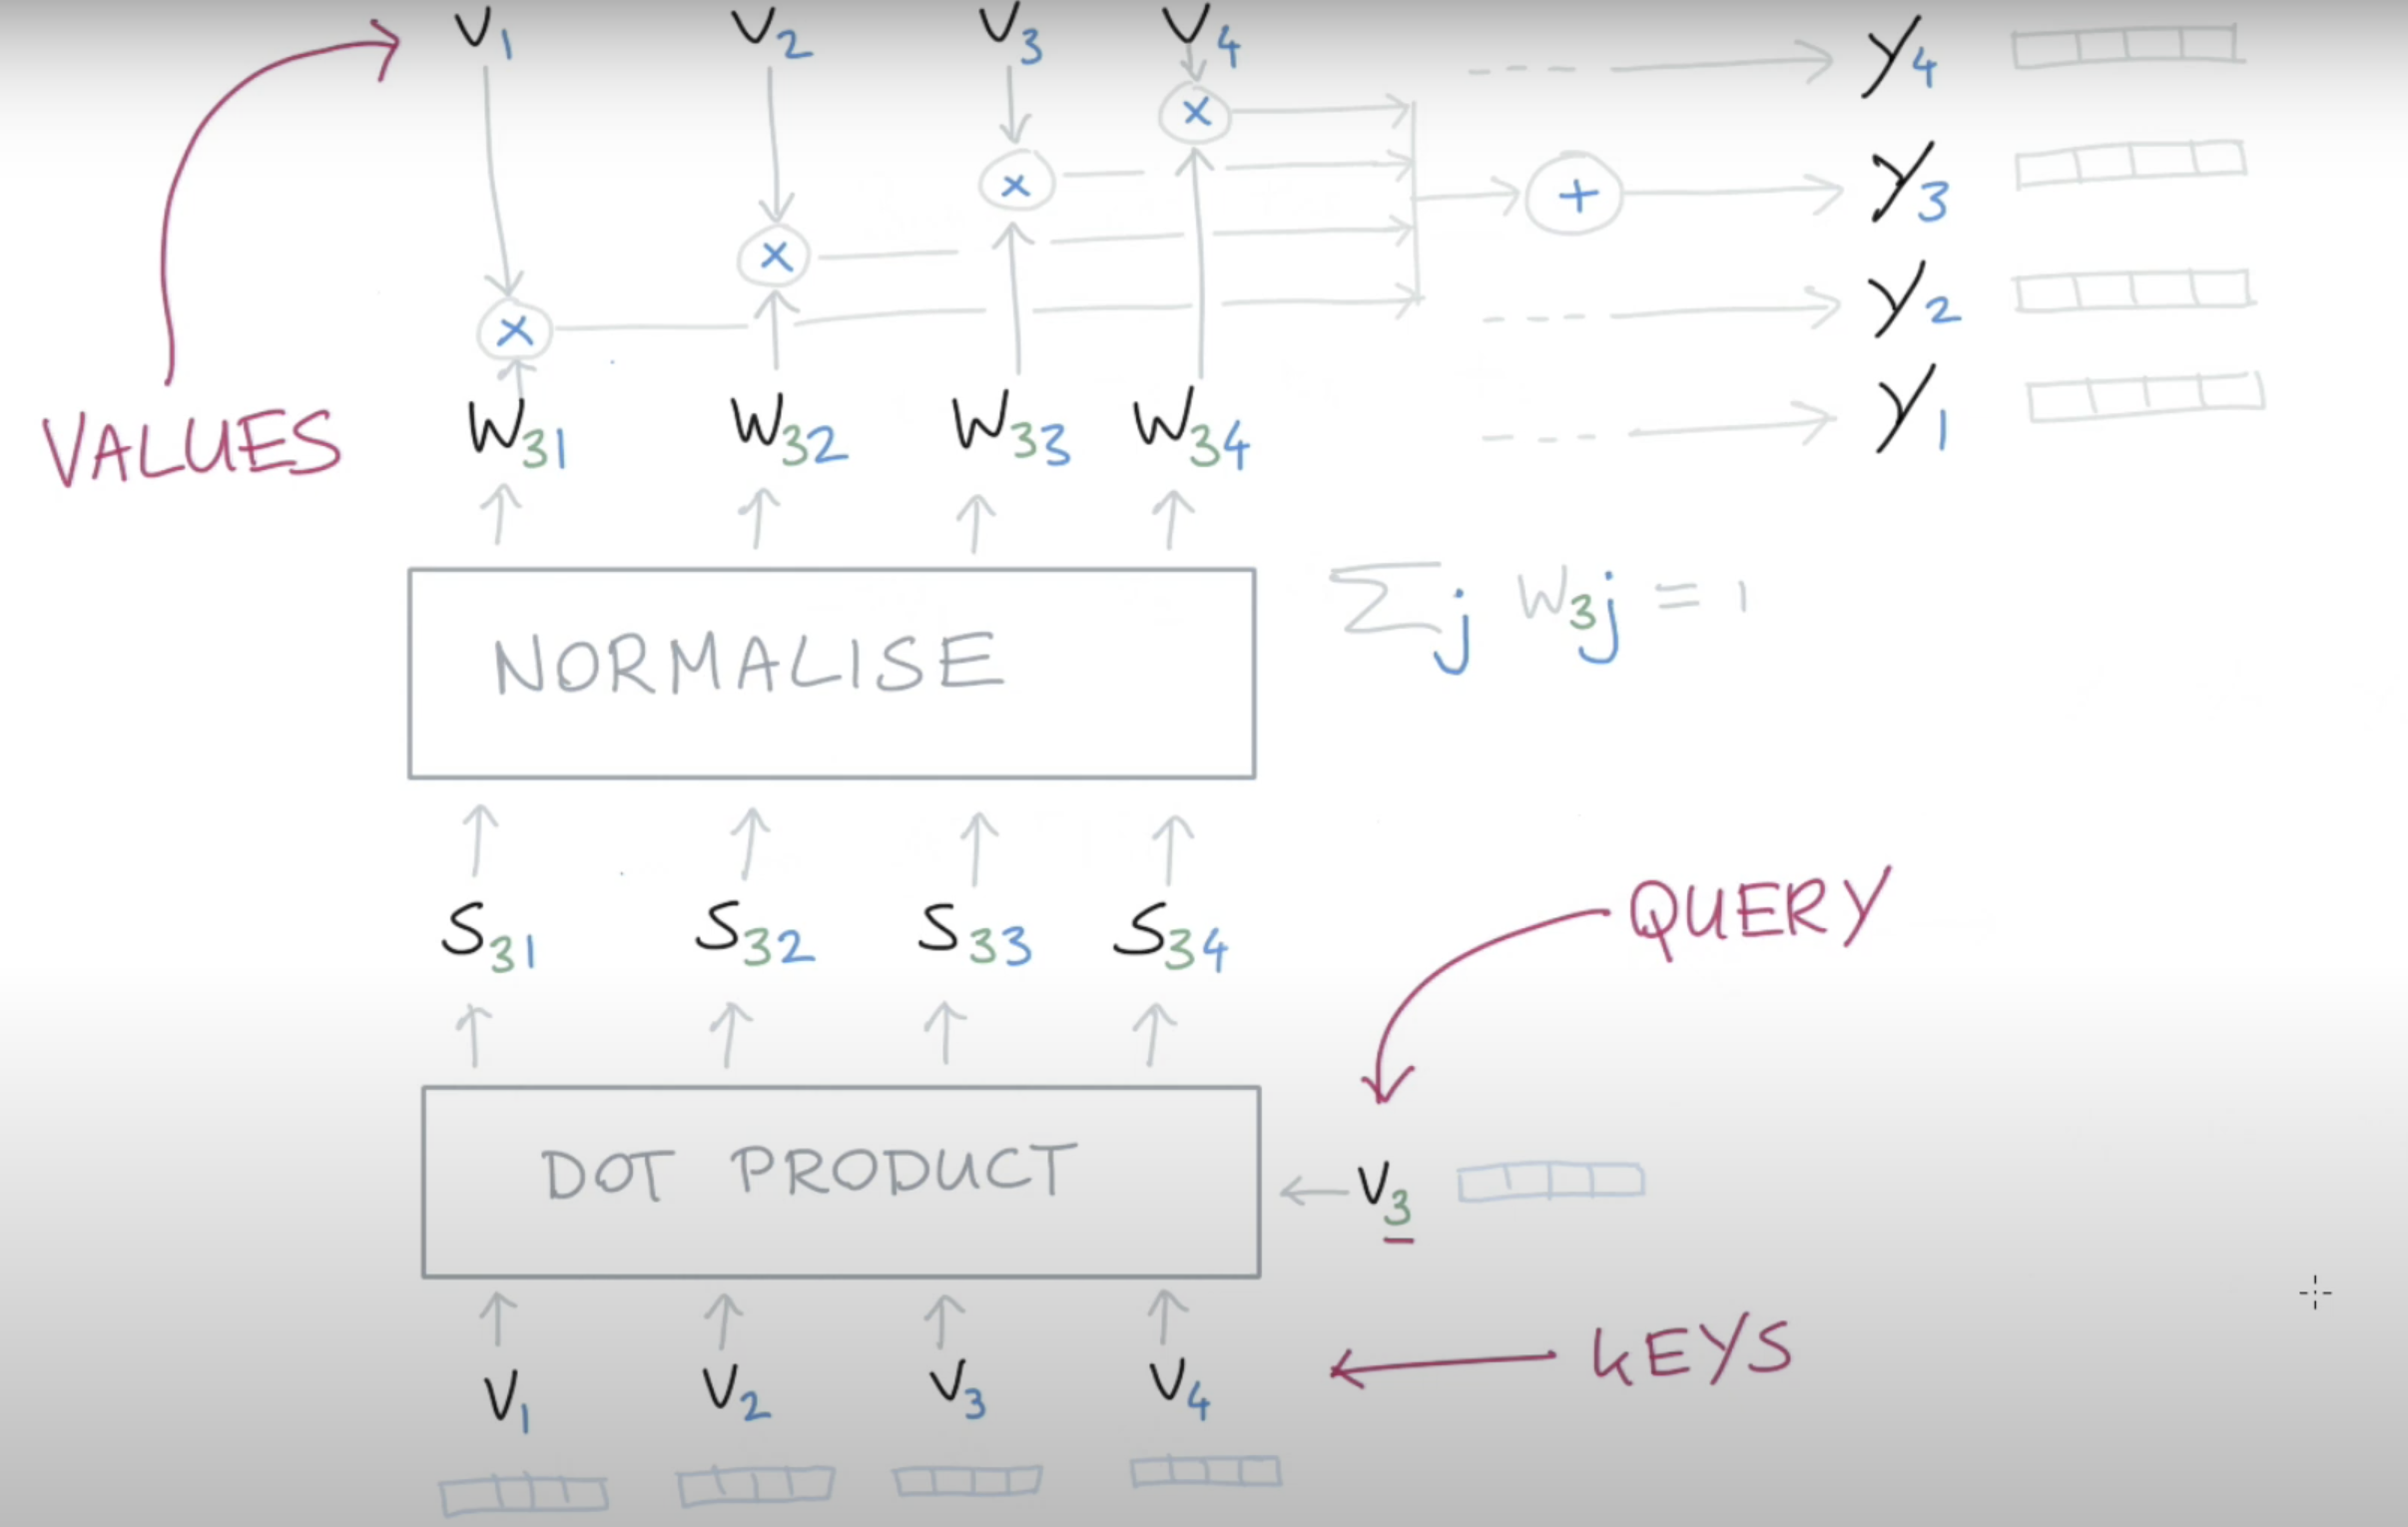

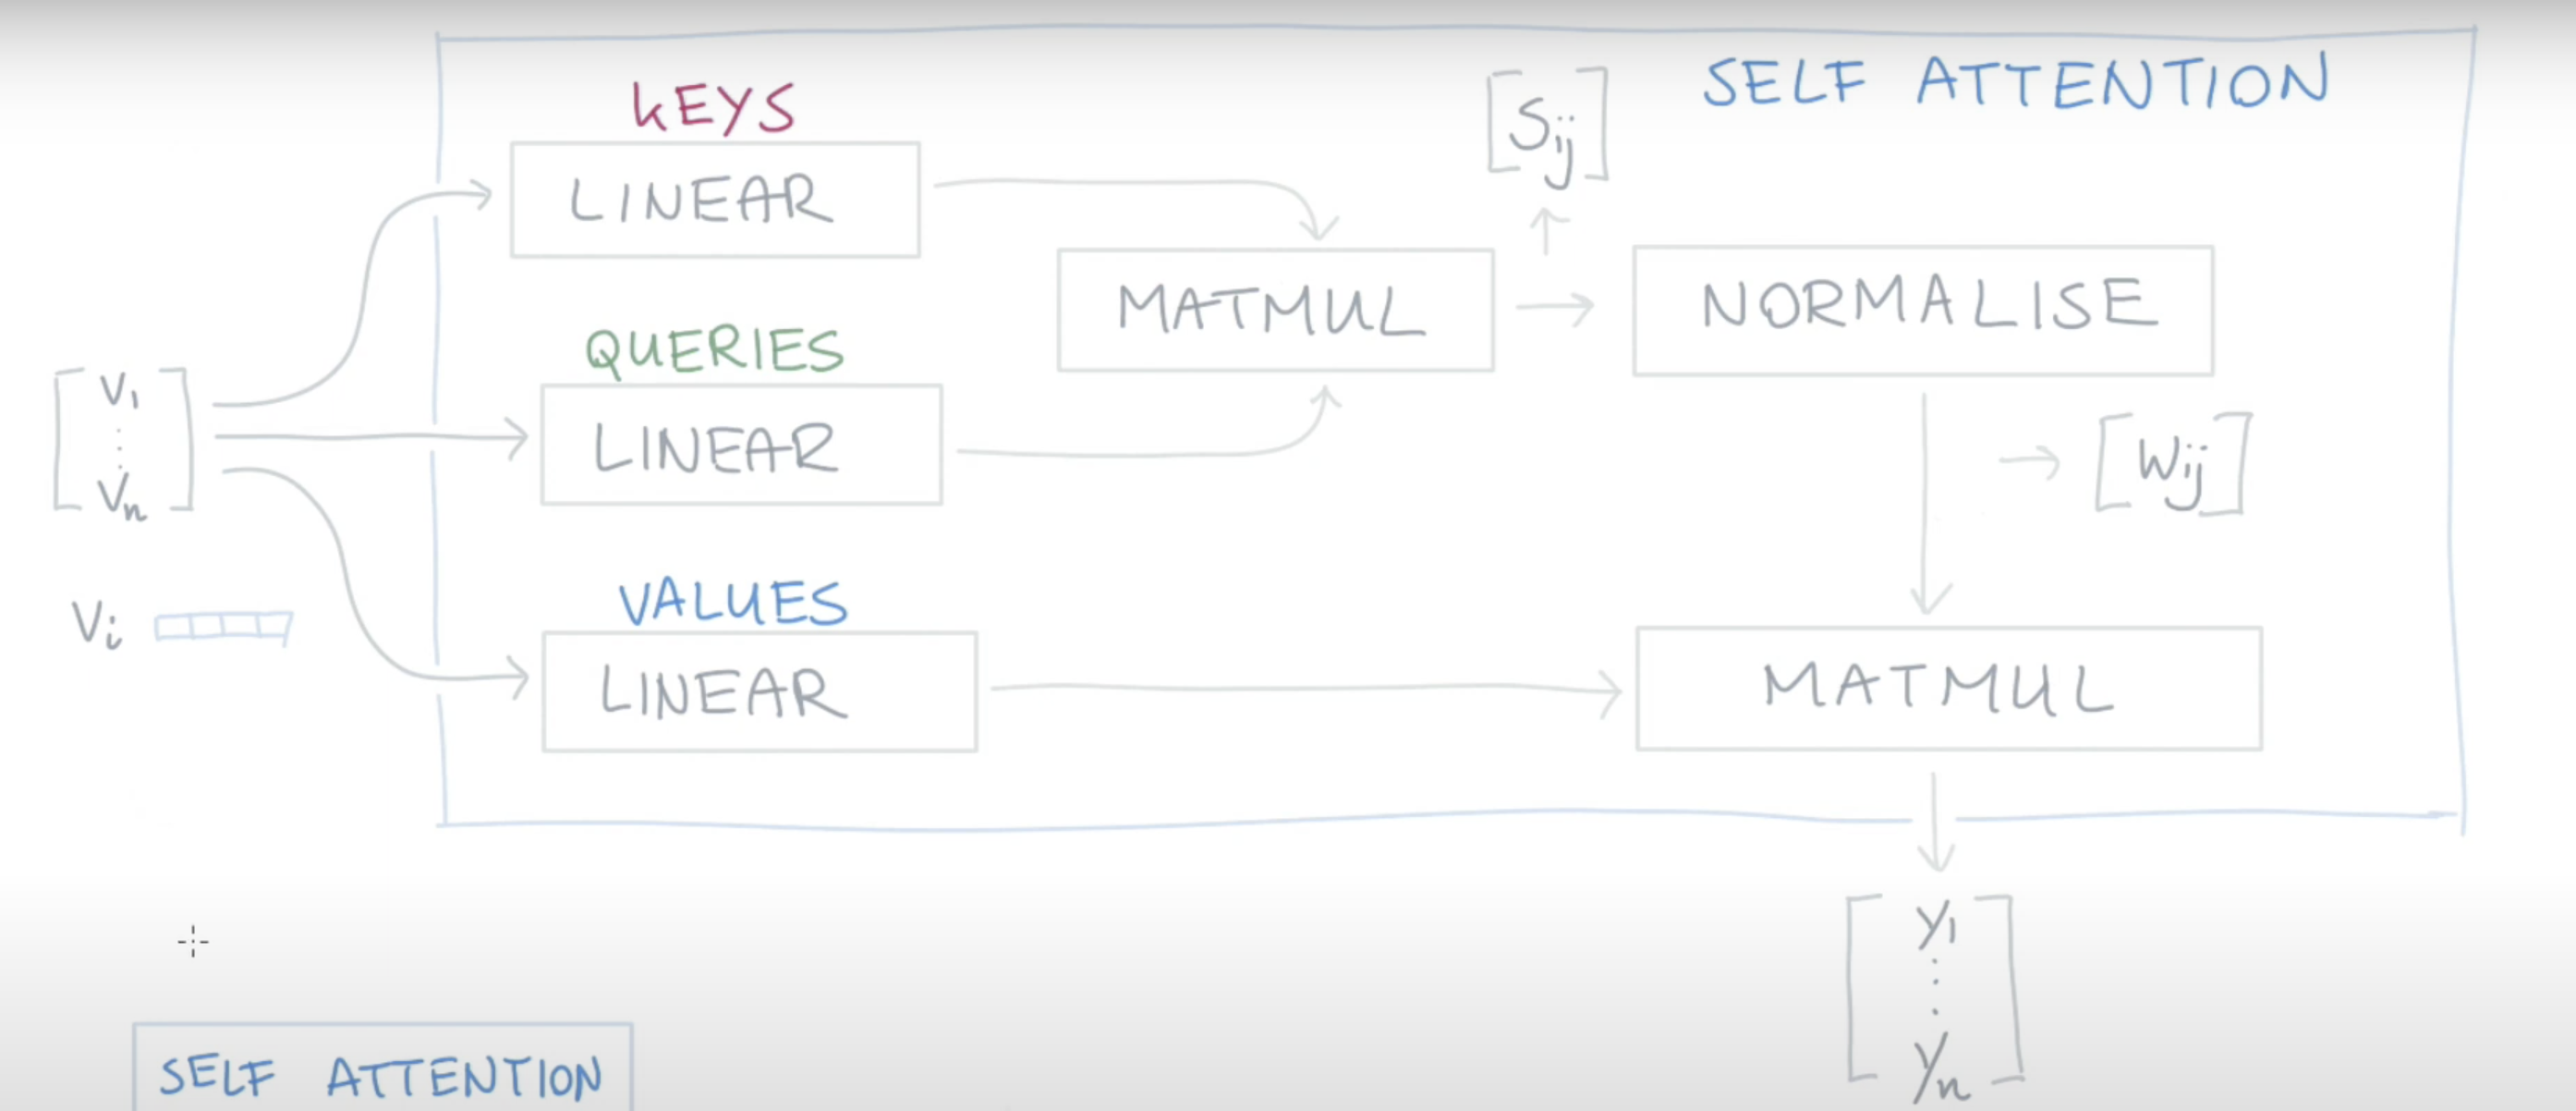

In [26]:
embed_mat.weight

Parameter containing:
tensor([[ 2.2013,  0.2880, -0.6691],
        [ 0.1541, -0.5143,  0.9649],
        [ 0.0156,  1.5483,  2.0343],
        [ 2.1113,  0.8245, -0.4114],
        [-0.1357,  1.0630,  1.0255],
        [-0.3377,  0.0520, -0.8801]], requires_grad=True)

In [27]:
# let's take e3 as query
x_3=embed_mat.weight[2]

In [28]:
# create the query, key and val params ==> .shape[0] == x_3.shape[0]
in_dim=x_3.shape[0]
out_dim=2

In [29]:
w_key=torch.nn.Parameter(torch.randn(in_dim,out_dim),requires_grad=False)
w_query=torch.nn.Parameter(torch.randn(in_dim,out_dim),requires_grad=False)
w_val=torch.nn.Parameter(torch.randn(in_dim,out_dim),requires_grad=False)

In [30]:
print(w_key)
print(w_query)
print(w_val)

Parameter containing:
tensor([[ 0.2949, -1.7259],
        [ 0.8759, -2.4090],
        [-0.0553,  0.7848]])
Parameter containing:
tensor([[ 1.6354, -0.4532],
        [ 1.0248, -0.8914],
        [ 0.4758, -1.1587]])
Parameter containing:
tensor([[-0.6729,  1.5347],
        [-1.6399, -0.3343],
        [ 0.2990,  1.8347]])


In [31]:
# in_embed --> key_linear
in_key=embed_mat.weight @ w_key
# input_3: query --> query_linear
in3_query=x_3 @ w_query

print(f"inputs --> key_linear: {in_key}")
print(f"input3:query --> query_linear: {in3_query}")


inputs --> key_linear: tensor([[ 9.3838e-01, -5.0182e+00],
        [-4.5837e-01,  1.7303e+00],
        [ 1.2483e+00, -2.1603e+00],
        [ 1.3675e+00, -5.9530e+00],
        [ 8.3439e-01, -1.5218e+00],
        [-5.4311e-03, -2.3300e-01]], grad_fn=<MmBackward0>)
input3:query --> query_linear: tensor([ 2.5803, -3.7443], grad_fn=<SqueezeBackward4>)


In [32]:
# dot product
in_kq=in3_query @ in_key.T
print(f"the attention scores between x3 and other key {in_kq}")

the attention scores between x3 and other key tensor([21.2112, -7.6614, 11.3100, 25.8184,  7.8511,  0.8584],
       grad_fn=<SqueezeBackward4>)


In [33]:
# Normalization
norm_in_kq=F.softmax(in_kq,dim=-1)
norm_in_kq

tensor([9.8805e-03, 2.8548e-15, 4.9518e-07, 9.9012e-01, 1.5580e-08, 1.4311e-11],
       grad_fn=<SoftmaxBackward0>)

In [34]:
# inputs as a values
in_val=embed_mat.weight @ w_val
in_val

tensor([[-2.1537,  2.0544],
        [ 1.0282,  2.1788],
        [-1.9413,  3.2389],
        [-2.8958,  2.2099],
        [-1.3453,  1.3180],
        [-0.1211, -2.1505]], grad_fn=<MmBackward0>)

In [35]:
norm_in_kq @ in_val

tensor([-2.8885,  2.2083], grad_fn=<SqueezeBackward4>)

In [36]:
sum=0
for k,v in enumerate(norm_in_kq):
    sum+=v*in_val[k]
sum

tensor([-2.8885,  2.2083], grad_fn=<AddBackward0>)

## Build Compact Self Attention class
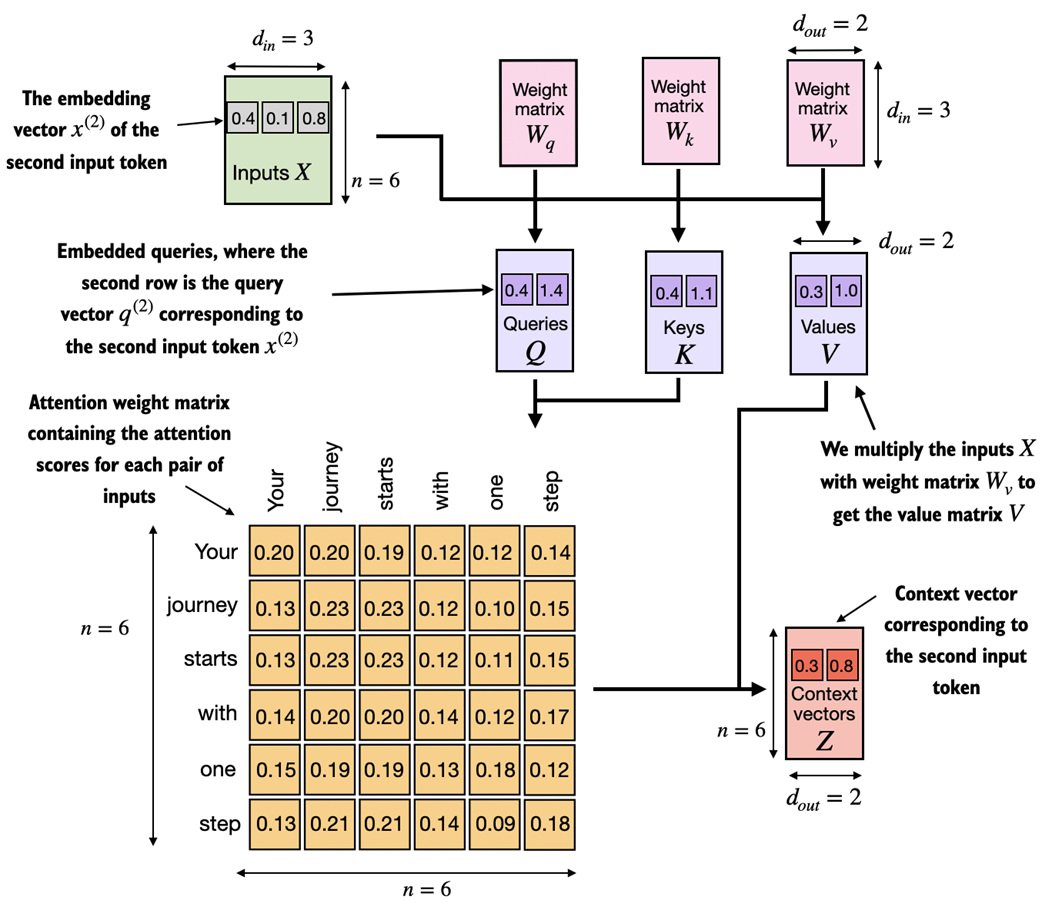

In [37]:
class SelfAttention_v1(nn.Module):
  def __init__(self,in_d,out_d):
    super().__init__()
    self.in_dim=in_d
    self.out_dim=out_dim
    self.W_key=nn.Parameter(torch.randn(self.in_dim,self.out_dim))
    self.W_query=nn.Parameter(torch.randn(self.in_dim,self.out_dim))
    self.W_value=nn.Parameter(torch.randn(self.in_dim,self.out_dim))

  def forward(self,X):
    att_weights=self.__attentions_scores(X)
    return self.__vect_context(att_weights,X)

  def __attentions_scores(self,X):
    queries = X @ self.W_query
    keys = X @ self.W_key
    scores=queries @ keys.T
    norm_scores=torch.softmax(scores/keys.shape[-1]**0.5,dim=-1)
    return norm_scores

  def __vect_context(self,att_weights,X):
    values=X@self.W_value
    return att_weights @ values

In [38]:
self_att=SelfAttention_v1(3,2)
self_att.forward(embed_mat.weight)

tensor([[ 0.9307,  0.3961],
        [ 0.3018, -0.5452],
        [ 0.6243,  0.6651],
        [ 0.8135,  0.8503],
        [ 0.6793,  0.7020],
        [ 0.7306,  1.7681]], grad_fn=<MmBackward0>)

### Self Attention With Pytorch

In [39]:
class SelfAttention_v2(nn.Module):
  def __init__(self,in_d,out_d,b_qkv=False):
    super().__init__()
    self.in_dim=in_d
    self.out_dim=out_d
    self.w_key=nn.Linear(in_d,out_d,b_qkv)
    self.w_query=nn.Linear(in_d,out_d,b_qkv)
    self.w_value=nn.Linear(in_d,out_d,b_qkv)
  def forward(self,X):
    scores_weights=self.__attentions_scores(X)
    context_vects=self.__context_vects(scores_weights,X)
    return context_vects
  def __attentions_scores(self,X):
    queries=self.w_query(X)
    keys=self.w_key(X)
    scores=queries @ keys.T
    weights=torch.softmax(scores/keys.shape[-1]**0.5,dim=-1)
    return weights
  def __context_vects(self,weights,X):
    values=self.w_value(X)
    return weights@values

In [40]:
self_att_v2=SelfAttention_v2(3,2)
self_att_v2.forward(embed_mat.weight)

tensor([[ 0.1037, -0.2443],
        [-0.2420,  0.0207],
        [-0.3669,  0.1416],
        [ 0.0941, -0.2238],
        [-0.2812,  0.0739],
        [-0.1202, -0.0618]], grad_fn=<MmBackward0>)

## Causual Self Attention : Masked Attention
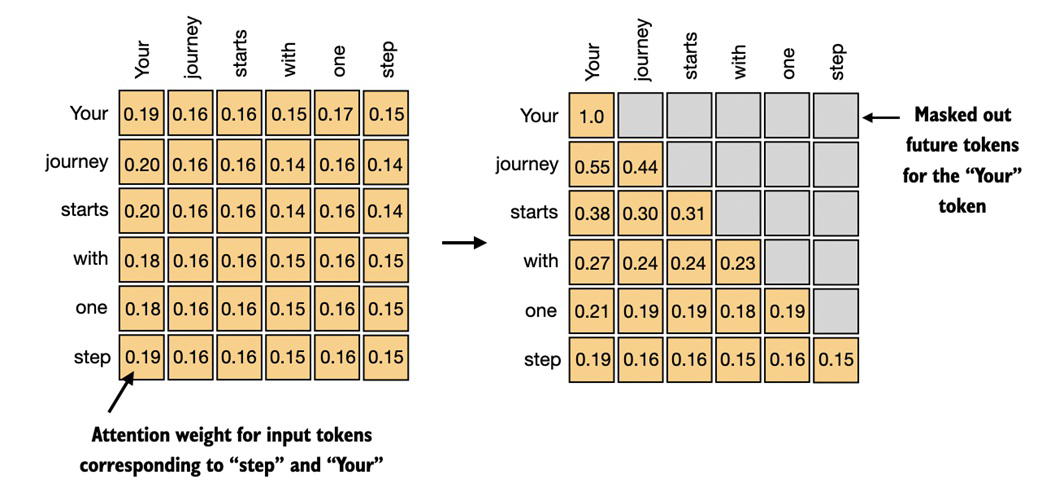

To Implement the causual SA we need to follow next schema:
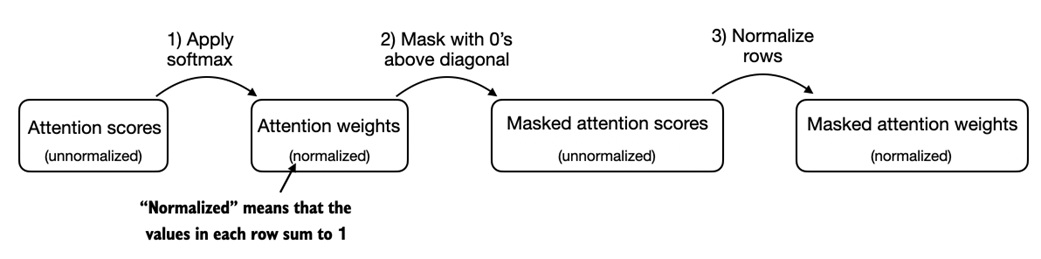

In [41]:
1# calculate attentions weightd with Self
context_lenght=embed_mat.weight.shape[0]
in_dim,out_dim=embed_mat.weight.shape[1],embed_mat.weight.shape[0]
w_key=nn.Linear(in_dim,out_dim)
w_query=nn.Linear(in_dim,out_dim)
# calculate attentions weight
keys=w_key(embed_mat.weight)
queries=w_query(embed_mat.weight)
attention_scores=queries @ keys.T
# calculate attention weights
attention_weights=torch.softmax(attention_scores/context_lenght**0.5,dim=-1)
print(attention_weights)

tensor([[0.1516, 0.1313, 0.0753, 0.1347, 0.1322, 0.3748],
        [0.1546, 0.1470, 0.2611, 0.1765, 0.1764, 0.0843],
        [0.2292, 0.1261, 0.1266, 0.2280, 0.1354, 0.1547],
        [0.1598, 0.1191, 0.0585, 0.1368, 0.1156, 0.4102],
        [0.2320, 0.1344, 0.1148, 0.2217, 0.1302, 0.1669],
        [0.2296, 0.1524, 0.1002, 0.2055, 0.1239, 0.1883]],
       grad_fn=<SoftmaxBackward0>)


In [42]:
2# generate tril matrix
mask_mat=torch.tril(torch.ones((context_lenght,context_lenght)))
print(mask_mat)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [43]:
masked_attention_scores=attention_weights * mask_mat
print(masked_attention_scores)

tensor([[0.1516, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1546, 0.1470, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2292, 0.1261, 0.1266, 0.0000, 0.0000, 0.0000],
        [0.1598, 0.1191, 0.0585, 0.1368, 0.0000, 0.0000],
        [0.2320, 0.1344, 0.1148, 0.2217, 0.1302, 0.0000],
        [0.2296, 0.1524, 0.1002, 0.2055, 0.1239, 0.1883]],
       grad_fn=<MulBackward0>)


In [44]:
masked_attention_scores[masked_attention_scores==0]=-torch.inf

In [45]:
#softmax(-00)=0
print(masked_attention_scores)

tensor([[0.1516,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1546, 0.1470,   -inf,   -inf,   -inf,   -inf],
        [0.2292, 0.1261, 0.1266,   -inf,   -inf,   -inf],
        [0.1598, 0.1191, 0.0585, 0.1368,   -inf,   -inf],
        [0.2320, 0.1344, 0.1148, 0.2217, 0.1302,   -inf],
        [0.2296, 0.1524, 0.1002, 0.2055, 0.1239, 0.1883]],
       grad_fn=<IndexPutBackward0>)


In [46]:
masked_attention_weights=torch.softmax(masked_attention_scores,dim=1)
masked_attention_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5019, 0.4981, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3566, 0.3216, 0.3218, 0.0000, 0.0000, 0.0000],
        [0.2603, 0.2500, 0.2353, 0.2544, 0.0000, 0.0000],
        [0.2132, 0.1934, 0.1897, 0.2111, 0.1926, 0.0000],
        [0.1773, 0.1641, 0.1558, 0.1731, 0.1595, 0.1701]],
       grad_fn=<SoftmaxBackward0>)

## Dropout:

* In GPT they applied it in two specific areas:
  
  - after calculating Attention scores
  - after calculating context vects

* in GPT we will use threshold between 0 and .5

fatal: not a git repository (or any of the parent directories): .git
